In [13]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
from plot_gtsam import plot_pose
from numpy import random
from typing import Union
import symforce.symbolic as sf


# Let us recall... SE2: Trying to make a circle

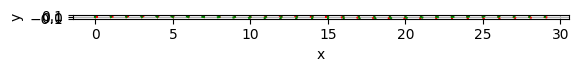

In [14]:
vx = 1.0
vy = 0.0
omega = 2 * np.pi/30

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for t in range(30): #run for 30 seconds
    p = gtsam.Pose2(vx*t , vy*t , omega*t)
    plot_pose(ax, p)

# SE-2 is a Lie group
![lie1](compose-retract.png)

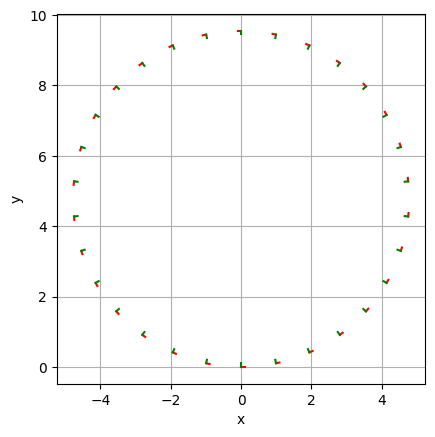

In [15]:
p = gtsam.Pose2(0.0 , 0.0 , 0.0)
twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]
tau = twist * dt
dp = gtsam.Pose2(tau[0],tau[1],tau[2])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()


for ii in range(30):
    #THESE TWO OPTIONS WILL BE THE SAME
    p = p.compose(gtsam.Pose2.Expmap(twist * dt))
    # p = p.compose(dp)

    plot_pose(ax, p)

# Adding noise to the actions (dp_tanget)

In reality, we dont have access to the actual motion of the robot. </br>
We get crude measurements... lets assume these measurements distribute normally around the actual motion

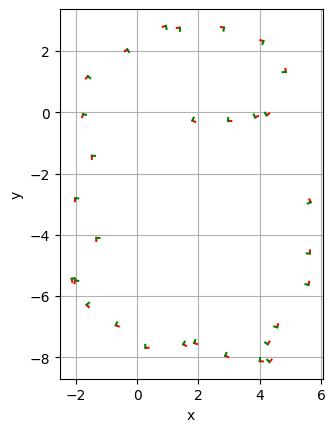

In [16]:
COV_R = np.diag([0.5,0.1,0.1]) #<----------------ADDED THIS LINE

p = gtsam.Pose2(0.0 , 0.0 , 0.0)
twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]
tau = twist * dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for ii in range(30):
    tmp = random.multivariate_normal(tau,COV_R) #<----------------ADDED THIS LINE
    p = p.compose(gtsam.Pose2.Expmap(tmp)) #<----------------ADDED THIS LINE
    plot_pose(ax, p)

# Lets add a noisy GPS measurement, that we also asssume distributed normaly

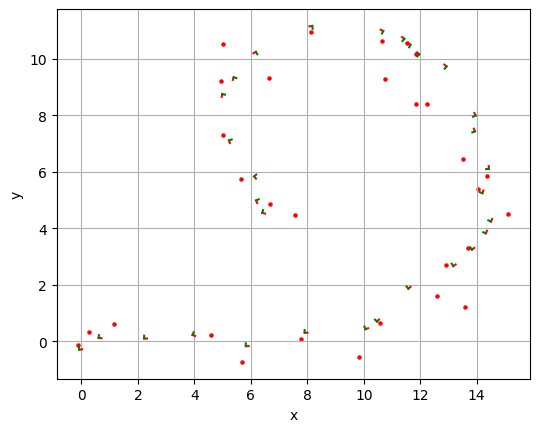

In [17]:
COV_R = np.diag([0.5,0.1,0.1])
COV_Q = np.diag([0.5,0.5]) #<----------------ADDED THIS LINE

p = gtsam.Pose2(0.0 , 0.0 , 0.0)
twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]
tau = twist * dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for ii in range(30):
    tmp = random.multivariate_normal(tau,COV_R)
    p = p.compose(gtsam.Pose2.Expmap(tmp)) 
    
    z_gps = random.multivariate_normal(p.translation(),COV_Q) #<----------------ADDED THIS LINE

    plot_pose(ax, p)
    ax.scatter(z_gps[0],z_gps[1],color='r', s = 5) #<----------------ADDED THIS LINE

# Problem? We need to seperate ground truth from estimation

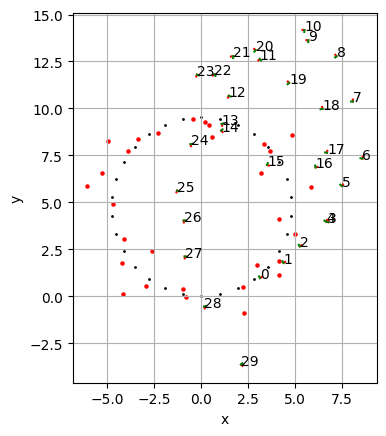

In [18]:
COV_R = np.diag([0.5,0.1,0.1])
COV_Q = np.diag([0.5,0.5])

p_gt = gtsam.Pose2(0.0 , 0.0 , 0.0) 
p_est = gtsam.Pose2(0.0 , 0.0 , 0.0) #<----------------ADDED THIS LINE

twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]
tau = twist * dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for ii in range(30):
    tmp = random.multivariate_normal(tau,COV_R)
    p_est = p_est.compose(gtsam.Pose2.Expmap(tmp)) #<----------------ADDED THIS LINE
    
    p_gt = p_gt.compose(gtsam.Pose2.Expmap(twist * dt))
    tmp = random.multivariate_normal(tau,COV_R)
    p_est = p_est.compose(gtsam.Pose2.Expmap(tmp)) #<----------------ADDED THIS LINE
    
    z_gps = random.multivariate_normal(p_gt.translation(),COV_Q)

    plot_pose(ax, p_est)
    ax.scatter(z_gps[0],z_gps[1],color='r', s = 5)
    ax.scatter(p_gt.x(), p_gt.y(), color = 'k', s = 1)
    ax.text(p_est.x(),p_est.y(), ii)

# Using Extended Kalam filter to fuse GPS measurements into our "dead reckoning" estimation

![kalman](kalman.jpg)

![EKF](EKF.png)

g - transition model(x,u) -> x </br>
h - measurement model(x)  -> z</br>

G - dg/dx </br>
H - dh/dx </br>


R - model noise </br>
Q - measurement noise </br>

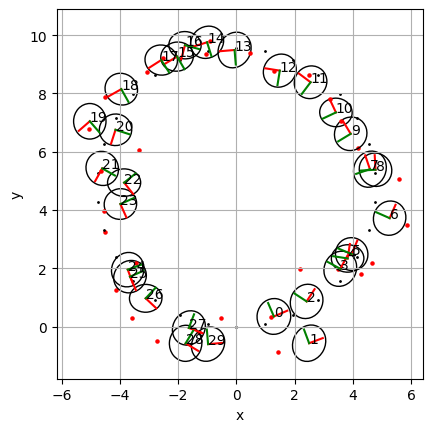

In [19]:
def g(p : gtsam.Pose2, tau : np.ndarray) -> gtsam.Pose2:
    #prediction model
    return p.compose(gtsam.Pose2.Expmap(tau))

def h(p : gtsam.Pose2) -> np.ndarray:
    #measurement model
    return p.translation()

def compute_G(p : gtsam.Pose2 , tau : np.ndarray) -> np.ndarray:
    #d(g(p))/dp
    return np.linalg.inv(gtsam.Pose2.AdjointMap(gtsam.Pose2.Expmap(tau)))

def compute_H(p) -> np.ndarray:
    t = p.theta()
    return np.array([[np.cos(t), -np.sin(t) ,0], 
                    [np.sin(t), np.cos(t), 0]])

def EKF(mu_tm1 : gtsam.Pose2, 
        cov_tm1 : np.ndarray,
        u_t : np.ndarray, 
        z_t : np.ndarray) -> Union[gtsam.Pose2, np.ndarray]:

    H_t = compute_H(mu_tm1)
    G_t = compute_G(mu_tm1, u_t)

    #prediction
    mu_t_bar = g(mu_tm1, u_t)
    cov_t_bar = G_t @ cov_tm1 @ G_t.T  + COV_R

    #kalman gain
    K_t = cov_t_bar @ H_t.T @ np.linalg.inv(H_t @ cov_t_bar @ H_t.T + COV_Q)

    #correction
    innovation = z_t - h(mu_t_bar)
    mu_t = mu_t_bar.compose(gtsam.Pose2.Expmap((K_t @ innovation)))
    cov_t = (np.eye(3) - K_t @ H_t) @ cov_t_bar

    return mu_t, cov_t

COV_R = np.diag([0.5,0.1,0.1])
COV_Q = np.diag([0.5,0.5])

p_gt = gtsam.Pose2(0.0 , 0.0 , 0.0) 
p_est = gtsam.Pose2(0.0 , 0.0 , 0.0)
p_cov = np.diag([0.5,0.5,0.5])

twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for ii in range(30):
    p_gt = p_gt.compose(gtsam.Pose2.Expmap(twist * dt))
    
    noisy_tau = random.multivariate_normal(twist*dt,COV_R)
    z_gps = random.multivariate_normal(p_gt.translation(),COV_Q)
    p_est, p_cov = EKF(p_est, p_cov, noisy_tau, z_gps)
    
    plot_pose(ax, p_est, p_cov, 0.5)
    ax.text(p_est.x(),p_est.y(), ii)
    ax.scatter(z_gps[0],z_gps[1],color='r', s = 5)
    ax.scatter(p_gt.x(), p_gt.y(), color = 'k', s = 1)

# How to calcualte H?

![derivatives](derivatives.png)

In [20]:
x = sf.symbols('x')
y = sf.symbols('y')
theta = sf.symbols('theta')
R = sf.Rot2.symbolic(theta)
t = sf.V2(x,y)
p = sf.Pose2_SE2(R,t)

print('variable order:')
print(p.to_storage(),end='\n\n')

print('jacobian via variable order:',end ='')
p.t.jacobian(p)


variable order:
[theta_re, theta_im, x, y]

jacobian via variable order:

[0, theta_re, -theta_im]
[0, theta_im, theta_re]

## Blah I want it in my order:

In [21]:
v = [x,y,theta]
H = sf.Matrix23()
for i in range(2):
    for j in range(3):
        H[i,j] = p.t[i].diff(v[j])
print("H = :")
print(H)
print("This is a wrong answer")

H = :
[1, 0, 0]
[0, 1, 0]

This is a wrong answer


## Intuition?

In [22]:
# we want to compute h(p*exp(tau^)):
# tau^ = (zeta*t)^

tau_x = sf.symbols('tau_x')
tau_y = sf.symbols('tau_y')
tau_theta = sf.symbols('tau_theta')
tau = [tau_theta,tau_x,tau_y]

exp_tau_hat = sf.Matrix33.eye() + sf.Pose2_SE2.hat(tau) #from taylor series... remember?

ptau = p.to_homogenous_matrix() * exp_tau_hat
print("h = :")
print(ptau[:2,2])

tau = [tau_x,tau_y,tau_theta] # <------------------------- rearrange for clarity
H = sf.Matrix23()
for i in range(2):
    for j in range(3):
        H[i,j] = ptau[i,2].diff(tau[j])
print("H = :")
print(H)
print("this is the right answer")

h = :
[x + tau_x*theta_re - tau_y*theta_im]
[y + tau_x*theta_im + tau_y*theta_re]

H = :
[theta_re, -theta_im, 0]
[theta_im, theta_re, 0]

this is the right answer


# How to calcualte G?

https://arxiv.org/abs/1812.01537

In [23]:
x = sf.symbols('x')
y = sf.symbols('y')
theta = sf.symbols('theta')
R = sf.Rot2.symbolic(theta)
t = sf.V2(x,y)
p = sf.Pose2_SE2(R,t)

tau_x = sf.symbols('tau_x')
tau_y = sf.symbols('tau_y')
tau_theta = sf.symbols('tau_theta')
tau = [tau_theta,tau_x,tau_y]

ptau = p.retract(tau)
ptau_tangent = ptau.to_tangent()
ptau_tangent = [ptau_tangent[1], ptau_tangent[2], ptau_tangent[0]] # <------------------------- rearrange for clarity

tau = [tau_x,tau_y,tau_theta] # <------------------------- rearrange for clarity
G = sf.Matrix33()
for i in range(3):
    for j in range(3):
        G[i,j] = ptau_tangent[i].diff(tau[j]).simplify()
print("G = :")
print(G)


G = :
[0.5*atan2(sin(tau_theta)*theta_re + cos(tau_theta)*theta_im, -sin(tau_theta)*theta_im + cos(tau_theta)*theta_re)*(-theta_im + sin(tau_theta)*theta_im**2 + sin(tau_theta)*theta_re + sin(tau_theta)*theta_re**2 + cos(tau_theta)*theta_im)/((sin(tau_theta)*theta_re + cos(tau_theta)*theta_im)*tau_theta), 0.5*atan2(sin(tau_theta)*theta_re + cos(tau_theta)*theta_im, -sin(tau_theta)*theta_im + cos(tau_theta)*theta_re)*(-theta_re - sin(tau_theta)*theta_im - cos(tau_theta)*theta_im**2 + cos(tau_theta)*theta_re - cos(tau_theta)*theta_re**2 + theta_im**2 + theta_re**2)/((sin(tau_theta)*theta_re + cos(tau_theta)*theta_im)*tau_theta), 0.5*((sin(tau_theta)*theta_re + cos(tau_theta)*theta_im)**2*tau_theta*(y*tau_theta - (tau_x*(-1 + cos(tau_theta)) - tau_y*sin(tau_theta))*theta_re + (tau_x*sin(tau_theta) + tau_y*(-1 + cos(tau_theta)))*theta_im - atan2(sin(tau_theta)*theta_re + cos(tau_theta)*theta_im, -sin(tau_theta)*theta_im + cos(tau_theta)*theta_re)*(x*tau_theta + (tau_x*(-1 + cos(tau_theta))

In [24]:
def compute_G(p : gtsam.Pose2 , tau : np.ndarray) -> np.ndarray:
    #d(g(p))/dp
    return np.linalg.inv(gtsam.Pose2.AdjointMap(gtsam.Pose2.Expmap(tau)))

num_tau = np.random.random(3)
num_p = gtsam.Pose2.Expmap(np.random.random(3))

G_gtsam = compute_G(num_p,num_tau)
G_sf = G.subs([x,y,theta],[num_p.x(),num_p.y(),num_p.theta()])
G_sf = G_sf.subs(tau,num_tau.tolist())
theta_im = sf.symbols('theta_im')
theta_re = sf.symbols('theta_re')
G_sf = G_sf.subs(theta_re,np.cos(num_p.theta()))
G_sf = G_sf.subs(theta_im,np.sin(num_p.theta()))

print(G_sf.evalf())
print(G_gtsam)
print("FAIL")

[1.00359105955012, -0.11195215223877, 0.0348693276167338]
[0.11195215223877, 1.00359105955012, -0.0522304739988644]
[0.0, 0.0, 1.0]

[[ 0.91554458  0.40221651 -0.29932586]
 [-0.40221651  0.91554458  0.72247215]
 [ 0.          0.          1.        ]]
FAIL
